# Supervised Classification Using AstroML (Scikit-learn)
## Identifying RR Lyrae stars
This notebook is intended to be a tutorial for performing supervised classificaton with AstroML, which is itself based on scikit learn. The tutorial will teach you how to load data, split it into a training and a test set, and perform supervised classification using the logistic regression. 

First, we do all the relevant imports. Note specially the imports from sklearn and astroML. Scikit-learn has good online tutorials that is good to check:

http://scikit-learn.org/stable/supervised_learning.html#supervised-learning

And AstroML:

http://www.astroml.org/index.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib

from sklearn.linear_model import LogisticRegression
#from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from rrlyrae_mags_mod import fetch_rrlyrae_combined

We now get the data and plot it:

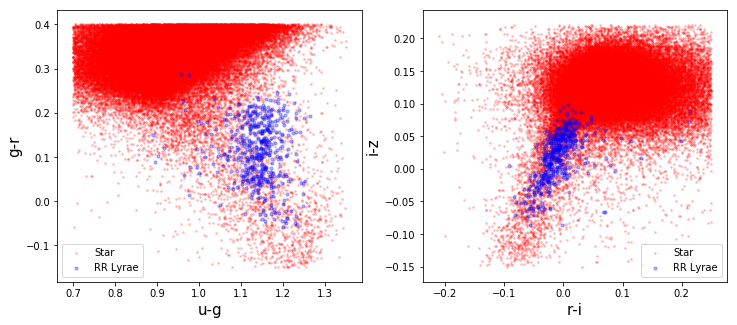

In [2]:
#get data 
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

# Let's plot it
fig = plt.figure(figsize=(12.0, 5.0))

#fig.subplots(1,2)
ax = fig.add_subplot(121)
ax.scatter(X[y==0.0][:,1],X[y==0.0][:,0],s=6, lw=0,color='r',alpha=0.3,label='Star')
ax.scatter(X[y==1.0][:,1],X[y==1.0][:,0],s=10, lw=1,color='b',alpha=0.3,label='RR Lyrae')
ax.set_xlabel('u-g',size=15)
ax.set_ylabel('g-r',size=15)
ax.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(X[y==0.0][:,3],X[y==0.0][:,2],s=6, lw=0,color='r',alpha=0.3,label='Star')
ax2.scatter(X[y==1.0][:,3],X[y==1.0][:,2],s=10, lw=1,color='b',alpha=0.3,label='RR Lyrae')
ax2.set_xlabel('r-i',size=15)
ax2.set_ylabel('i-z',size=15)
ax2.legend()

We now split the dataset into training and test sets. In general we want the training set to be significatively larger than the test set, as the algorithm will "learn" from the training set. We therefore set apart 75% of the dataset to be the training set:

In [3]:
# Split into training & testing sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)
N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
print('N_train = ',N_train)
N_test = len(y_test)
print('N_test = ',N_test)
N_plot = 5000 + N_rr

N_train =  69855
N_test =  23286


Let us look at the shape and dimensions of the dataset. Here, $X$ refers to the feature matrix. In this particular case, it contains each of the four photometric colors for each example in the dataset. On the other hand, $y$ corresponds to the labels of the examples. In this case, of course, $y$ takes only two values, either normal star (0) or RR lyrae star (1).

In [5]:
print(np.shape(X_train))
print(np.shape(y_train))

(69855, 4)
(69855,)


Let us look at one of them:

In [7]:
print(X_train[0])
print(y_train[0])

[0.35899925 0.7649994  0.14100075 0.16699982]
0.0


Nice, it looks like the first object is a normal star, as its label is 0. It's got a nice set of $u-g$, $g-r$, $r-i$, and $i-z$ photometric colors. Next, we define the logistic function, that we will use as the non-linear activation function of our neuron

In [8]:
# Let's define the logistic regression
def log_reg(x):
    return 1.0 / (1 + np.exp(-x))

As a try-and error exercise, let's take a subset of the data (so that we need few computations), visualize it, and then try to set arbitrary weights for the four features in question (the four colors). We then look at the output of the neuron for each example, given those weights, and see if the resulting probabilities agree with the target. Specifically, we want the probability to be high if the label is 0 (red dots), and low if the label is 1 (blue dots).

In [11]:
# Let's extract a small random subset of the data
#y_shuffle = np.random.shuffle(np.arange(len(y)))
#print (np.arange(len(y)))

y1 = y[-1000:]
X1 = X[-1000:]

arr = np.arange(len(y1))
np.random.shuffle(arr)
#len(y[y==1.])
#len(y[y==0.])

X_t = X1[arr][0:100]
y_t = y1[arr][0:100]


Text(0,0.5,'i-z')

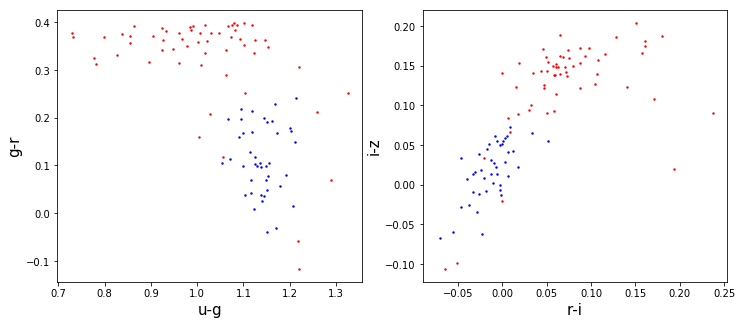

In [12]:
# Let's plot this subset
fig = plt.figure(figsize=(12.0, 5.0))

#fig.subplots(1,2)
ax = fig.add_subplot(121)
ax.scatter(X_t[y_t==1.0][:,1],X_t[y_t==1.0][:,0],s=6, lw=0,color='b')
ax.scatter(X_t[y_t==0.0][:,1],X_t[y_t==0.0][:,0],s=6, lw=0,color='r')
ax.set_xlabel('u-g',size=15)
ax.set_ylabel('g-r',size=15)
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(X_t[y_t==1.0][:,3],X_t[y_t==1.0][:,2],s=6, lw=0,color='b')
ax2.scatter(X_t[y_t==0.0][:,3],X_t[y_t==0.0][:,2],s=6, lw=0,color='r')
ax2.set_xlabel('r-i',size=15)
ax2.set_ylabel('i-z',size=15)

Let us try to guess what the weights should be. We start with a vector of ones and see what probabilities we get for both the red and the blue dots. Let's assume that we want the probability to be large for the red dots (normal stars) and small for the blue (RR Lyrae).

(array([ 1.,  1.,  0.,  1.,  0.,  6.,  5., 14., 14., 16.]),
 array([0.71768345, 0.73126111, 0.74483878, 0.75841644, 0.77199411,
        0.78557177, 0.79914944, 0.8127271 , 0.82630477, 0.83988243,
        0.8534601 ]),
 <a list of 10 Patch objects>)

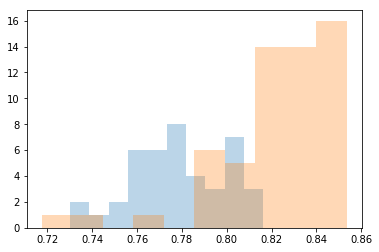

In [13]:
weights = np.ones(4)

# First the blue dots
prob_blue = []
for features in X_t[y_t==1.0]:
    prob_blue.append(log_reg(np.dot(weights,features)))

# Now the red
prob_red = []
for features in X_t[y_t==0.0]:
    prob_red.append(log_reg(np.dot(weights,features)))
plt.hist(prob_blue,alpha=0.3)
plt.hist(prob_red,alpha=0.3)

It looks like we do a reasonable job if the weights are just ones (uniform weights), but all objects would still be calssifeid as normal stars. Can we improve this? Let's see. 

(array([ 2.,  0.,  1.,  0.,  2.,  3.,  2.,  9., 24., 15.]),
 array([0.27768007, 0.31189204, 0.346104  , 0.38031597, 0.41452793,
        0.44873989, 0.48295186, 0.51716382, 0.55137578, 0.58558775,
        0.61979971]),
 <a list of 10 Patch objects>)

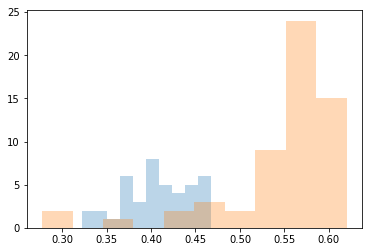

In [14]:
#weights = np.array([2.0,-0.5,2.0,0.2])
weights = np.array([1.5,-0.5,1.5,0.2])

# First the blue dots
prob_blue = []
for features in X_t[y_t==1.0]:
    prob_blue.append(log_reg(np.dot(weights,features)))

# Now the red
prob_red = []
for features in X_t[y_t==0.0]:
    prob_red.append(log_reg(np.dot(weights,features)))
plt.hist(prob_blue,alpha=0.3)
plt.hist(prob_red,alpha=0.3)

We can do better and better if we keep trying. But it is obvious that doing this by guessing makes no sense. Instead, we use the logistic regression classifier available as part of scikit-learn to perform this learning process automatically.

The following piece of code performs the logistic regression classifier with astroML. As you can see, it is very simple. You first initialize your classifier, then you fit the model using the trainig data, and finlly you predict for the test set, and see what the True Positive Rate (completeness) and False Positive Rate (contamination) are.

*Completeness* is the number of detected RR lyrae over the total number of RR-lyrae in the test set, whereas *contamination* is the fraction of normal stars that were misclassified as RR-lyrae stars.

In [21]:
#----------------------------------------------------------------------
# perform Classification
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

# Do this progressively for increasing number of colors.
for nc in Ncolors:
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print ("completeness", completeness)
print ("contamination", contamination)

completeness [0.98540146 1.         1.         1.        ]
contamination [0.88588335 0.84143519 0.8416185  0.84069767]


Now we just plot the decision boundary for one of the color pairs

In [22]:
#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

print (clf.intercept_)
print (clf.coef_)

# Here we predict the probabilities given our trained algorithm
Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

[-9.85508091]
[[-24.38288352  14.65695219]]


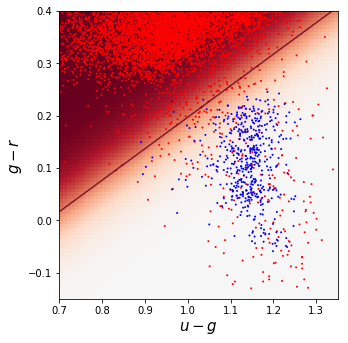

In [23]:
#----------------------------------------------------------------------
# plot the results
pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
matplotlib.rcParams.update(pgf_with_rc_fonts)

from matplotlib.colors import ListedColormap
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

fig = plt.figure(figsize=(10, 5.0))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=cm_bright, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=cm, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)

#ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
#ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
ax.contour(xx, yy, Z, [0.5], cmap=cm, alpha=.8)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$',size=15)
ax.set_ylabel('$g-r$',size=15)

# plot completeness vs Ncolors
#ax = fig.add_subplot(222)

#ax.plot(Ncolors, completeness, 'o-k', ms=6, color='g')

#ax.xaxis.set_major_locator(plt.MultipleLocator(1))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
#ax.xaxis.set_major_formatter(plt.NullFormatter())

#ax.set_ylabel('completeness',size=15)
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(-0.1, 1.1)
#ax.grid(True)

# plot contamination vs Ncolors
#ax = fig.add_subplot(224)
#ax.plot(Ncolors, contamination, 'o-k', ms=6, color='g')

#ax.xaxis.set_major_locator(plt.MultipleLocator(1))
#ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
#ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
#ax.set_xlabel('N colors',size=15)
#ax.set_ylabel('contamination',size=15)
#ax.set_xlim(0.5, 4.5)
#ax.set_ylim(-0.1, 1.1)
#ax.grid(True)

plt.show()

## Star-QSO classification using random forest
We will try to classify QSOs and stars based on their colors. For that we will use a Random Forest.

In [1]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib

from astroML.utils import split_samples
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Fetch data and split into training and test samples
from astroML.datasets import fetch_dr7_quasar
#from astroML.datasets import fetch_sdss_sspp
from sdss_sspp import fetch_sdss_sspp

quasars = fetch_dr7_quasar()
stars = fetch_sdss_sspp()

# Truncate data for speed
quasars = quasars[::5]
stars = stars[::5]

# stack colors into matrix X
Nqso = len(quasars)
Nstars = len(stars)
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['mag_u'] - quasars['mag_g']
X[:Nqso, 1] = quasars['mag_g'] - quasars['mag_r']
X[:Nqso, 2] = quasars['mag_r'] - quasars['mag_i']
X[:Nqso, 3] = quasars['mag_i'] - quasars['mag_z']

X[Nqso:, 0] = stars['upsf'] - stars['gpsf']
X[Nqso:, 1] = stars['gpsf'] - stars['rpsf']
X[Nqso:, 2] = stars['rpsf'] - stars['ipsf']
X[Nqso:, 3] = stars['ipsf'] - stars['zpsf']

y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)

Text(0,0.5,'$i - z$')

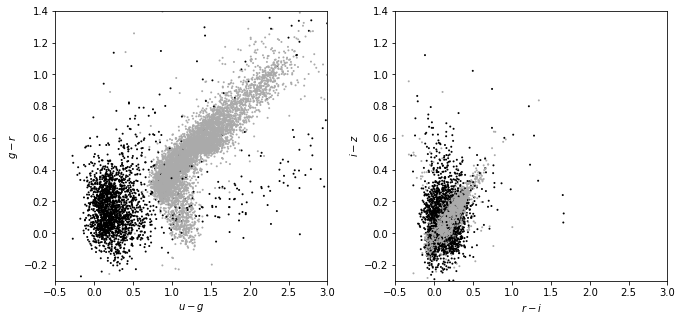

In [2]:
# Plot results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(121)
im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
ax1.set_xlim(-0.5, 3.0)
ax1.set_ylim(-0.3, 1.4)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - r$')

ax1 = fig.add_subplot(122)
im = ax1.scatter(X_test[:, 2], X_test[:, 3], c=y_test, s=4,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
ax1.set_xlim(-0.5, 3.0)
ax1.set_ylim(-0.3, 1.4)
ax1.set_xlabel('$r - i$')
ax1.set_ylabel('$i - z$')

In [3]:
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2)

In [4]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [5]:
# Accuracy
score = clf.score(X_test, y_test)

In [6]:
print(score)

0.9779471192702921


In [7]:
# Predict
y_pred = clf.predict(X_test)

In [31]:
y_prob = clf.predict_proba(X_test)
y_prob = y_prob.T[1]

In [32]:
from sklearn import metrics
# measure confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("True Positive (rate): ", cm[1,1], "({0:0.4f})".format(cm_norm[1,1]))
print("True Negative (rate): ", cm[0,0], "({0:0.4f})".format(cm_norm[0,0]))
print("False Positive (rate):", cm[1,0], "({0:0.4f})".format(cm_norm[1,0]))
print("False Negative (rate):", cm[0,1], "({0:0.4f})".format(cm_norm[0,1]))


True Positive (rate):  1992.0 (0.9222)
True Negative (rate):  6478.0 (0.9965)
False Positive (rate): 168.0 (0.0778)
False Negative (rate): 23.0 (0.0035)


In [33]:
np.shape(y_prob)

(8661,)

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)

In [35]:
# measure Area Under Curve (AUC)
auc = metrics.roc_auc_score(y_test, y_prob)
print()
print("AUC:", auc)


AUC: 0.9922493049502358


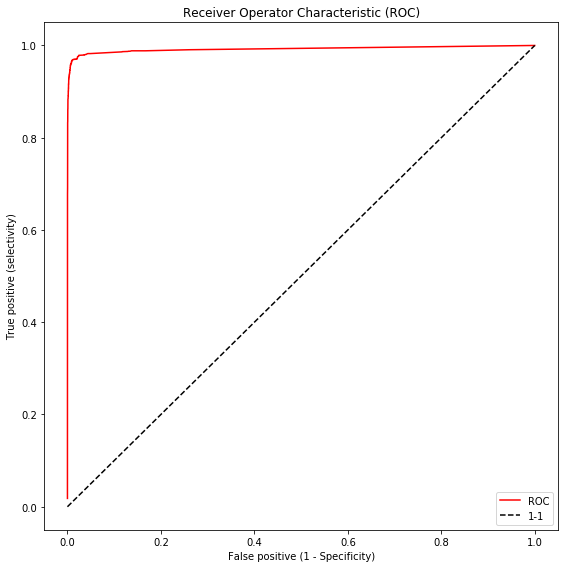

In [36]:
# ------------------------------------------------------------------------------
# Plot: Receiver-Operator Curve (ROC)
# ------------------------------------------------------------------------------

fig, axis1 = plt.subplots(figsize=(8,8))
plt.plot(fpr, tpr, 'r-', label='ROC')
plt.plot([0,1], [0,1], 'k--', label="1-1")
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False positive (1 - Specificity)")
plt.ylabel("True positive (selectivity)")
plt.legend(loc='lower right')
plt.tight_layout()

**Some relevant hyper-parameters for the random forest**

*max_depth*: max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. 

*n_estimators*: the number of decision trees used.

*max_features*: The number of features to consider when looking for the best split

**Feature importace**

We can rank the features according to how much each feature was used to split the dataset while training. This is a measure of their importance, i.e, of how much each feature contributes to successfully isolate pure partitions.

In [11]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.745794)
2. feature 1 (0.200941)
3. feature 2 (0.029077)
4. feature 3 (0.024188)
